In [1]:
import time

import adaptive
import numpy as np
from qcodes import Instrument, ManualParameter
from scipy import optimize

import quantify_core.analysis.optimization_analysis as oa
import quantify_core.visualization.pyqt_plotmon as pqm
from quantify_core.analysis.interpolation_analysis import InterpolationAnalysis2D
from quantify_core.data.handling import set_datadir
from quantify_core.measurement.control import MeasurementControl
from quantify_core.utilities.examples_support import default_datadir
from quantify_core.visualization.instrument_monitor import InstrumentMonitor

In [2]:
# We recommend to always set the directory at the start of the python kernel
# and stick to a single common data directory for all
# notebooks/experiments within your measurement setup/PC
# This sets a default data directory for tutorial purposes. Change it to your
# desired data directory.

In [3]:
set_datadir(default_datadir())

Data will be saved in:
/home/slavoutich/quantify-data


In [4]:
meas_ctrl = MeasurementControl("meas_ctrl")
insmon = InstrumentMonitor("Instruments Monitor")
plotmon = pqm.PlotMonitor_pyqt("plotmon_meas_ctrl")
meas_ctrl.instr_plotmon(plotmon.name)

In [5]:
para = Instrument("parabola")

para.add_parameter("x", unit="m", label="X", parameter_class=ManualParameter)
para.add_parameter("y", unit="m", label="Y", parameter_class=ManualParameter)

para.add_parameter(
    "noise", unit="V", label="white noise amplitude", parameter_class=ManualParameter
)
para.add_parameter(
    "acq_delay", initial_value=0.1, unit="s", parameter_class=ManualParameter
)


def _amp_model():
    time.sleep(
        para.acq_delay()
    )  # for display purposes, just so we can watch the live plot update
    return para.x() ** 2 + para.y() ** 2 + para.noise() * np.random.rand(1)


para.add_parameter("amp", unit="V", label="Amplitude", get_cmd=_amp_model)

In [6]:
meas_ctrl.settables([para.x, para.y])
af_pars = {
    "adaptive_function": optimize.minimize,  # used by meas_ctrl
    "x0": [-50, -50],  # used by `optimize.minimize` (in this case)
    "method": "Nelder-Mead",  # used by `optimize.minimize` (in this case)
    "options": {"maxfev": 100},  # limit the maximum evaluations of the gettable(s)
}
para.noise(0.5)
meas_ctrl.gettables(para.amp)
dset = meas_ctrl.run_adaptive("nelder_mead_optimization", af_pars)

Running adaptively...
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

In [7]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 100)
Coordinates:
    x0       (dim_0) float64 -50.0 -52.5 -50.0 -47.5 ... 0.02964 0.02929 0.02945
    x1       (dim_0) float64 -50.0 -50.0 -52.5 ... -0.0746 -0.07405 -0.07425
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 5e+03 5.256e+03 5.256e+03 ... 0.1594 0.4487 0.3904
Attributes:
    tuid:                             20230926-194441-293-d52f7a
    name:                             nelder_mead_optimization
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

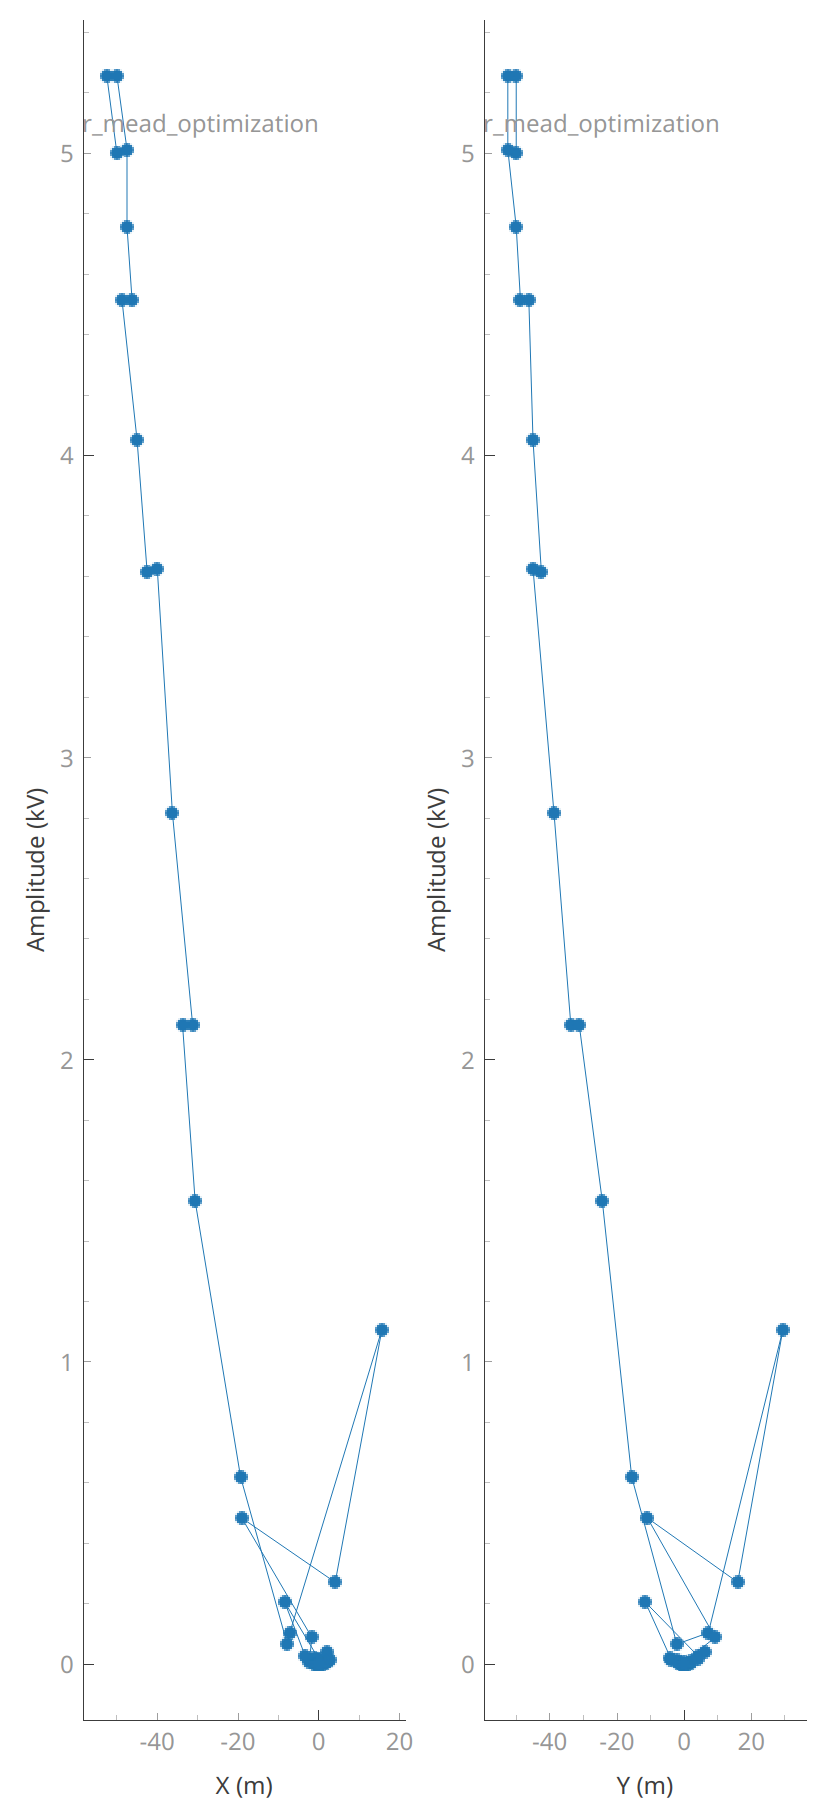

In [8]:
plotmon.main_QtPlot

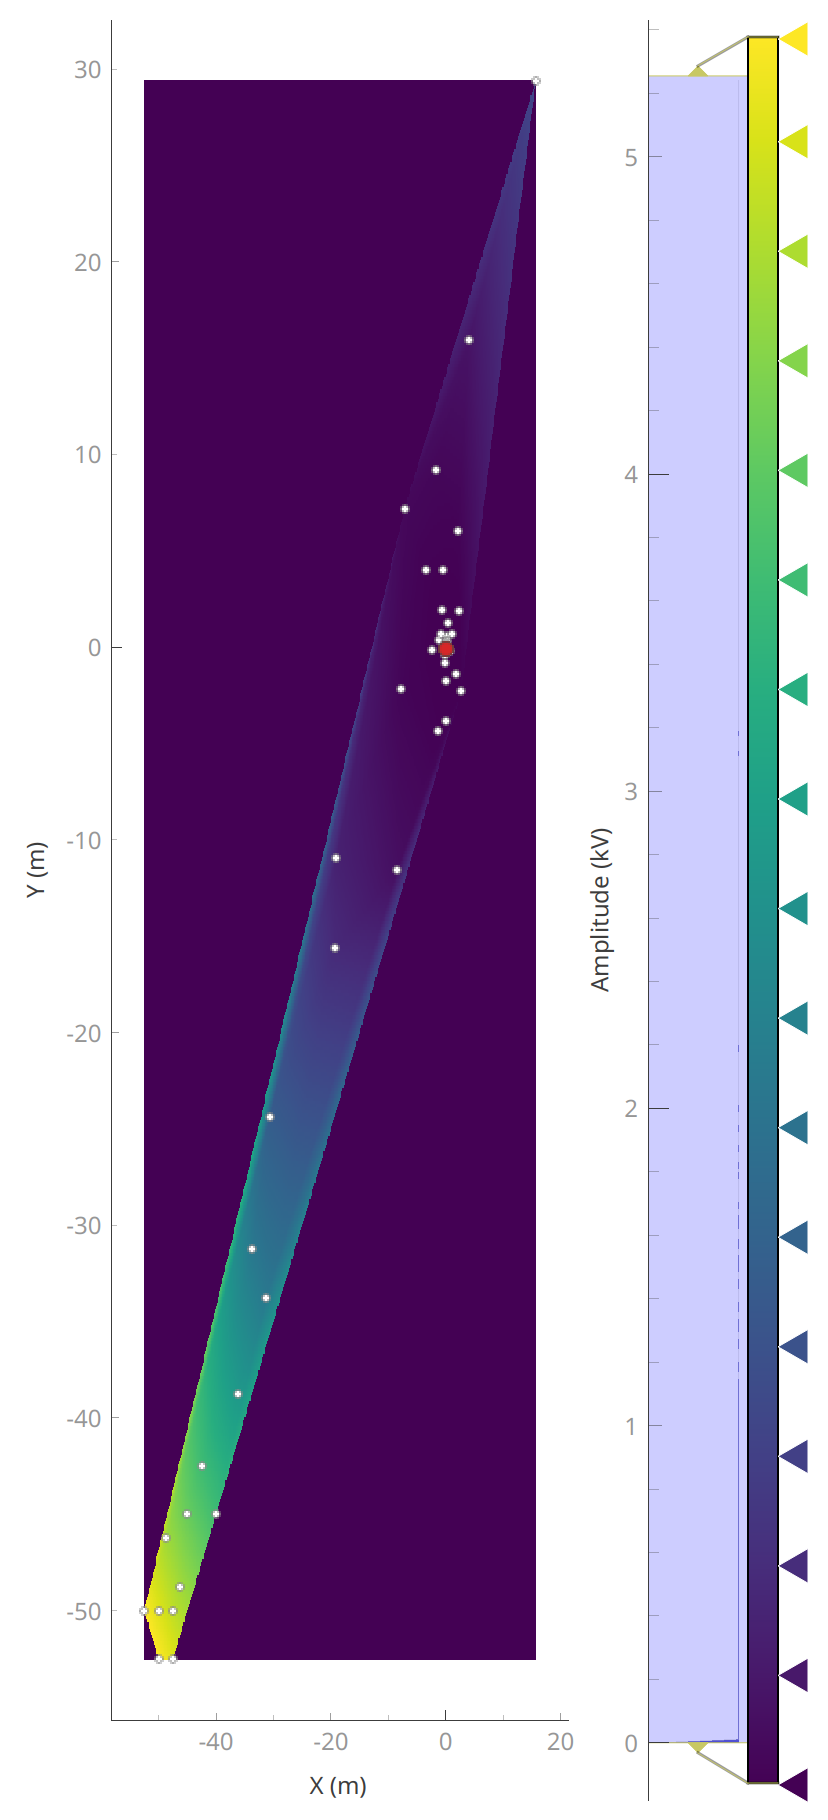

In [9]:
plotmon.secondary_QtPlot

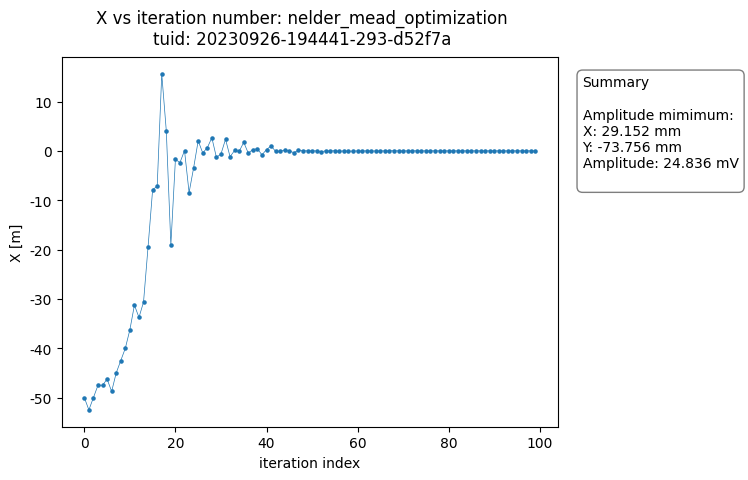

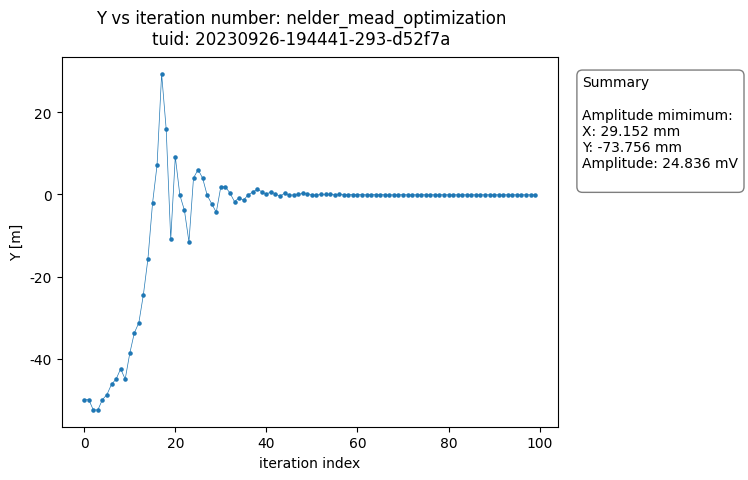

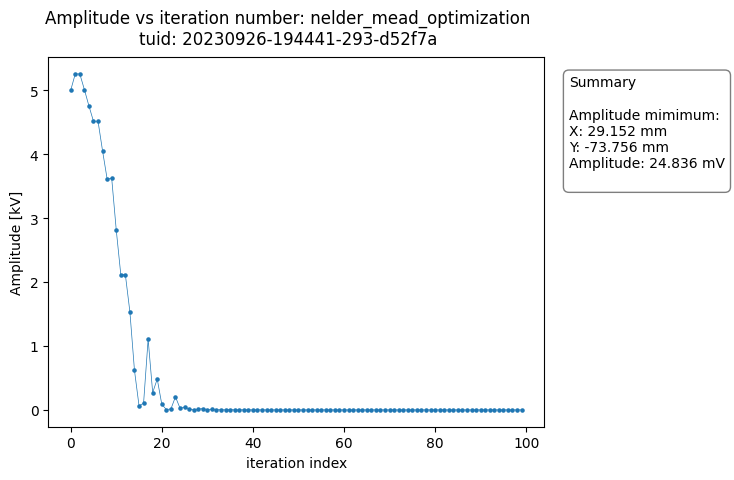

In [10]:
a_obj = oa.OptimizationAnalysis(dset)
a_obj.run()
a_obj.display_figs_mpl()

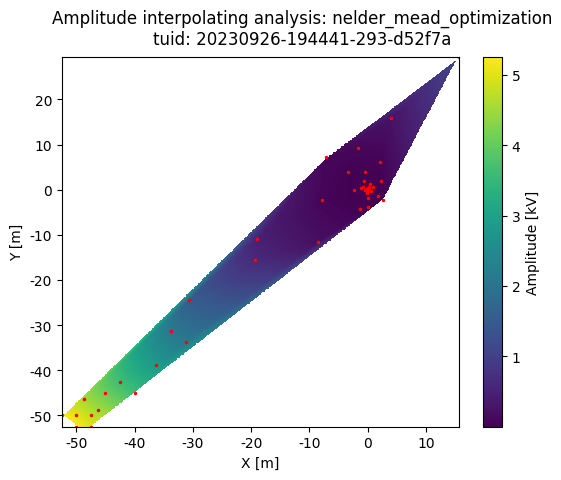

In [11]:
a_obj = InterpolationAnalysis2D(dset)
a_obj.run()
a_obj.display_figs_mpl()

In [12]:
res = Instrument("Resonator")

res.add_parameter("freq", unit="Hz", label="Frequency", parameter_class=ManualParameter)
res.add_parameter("amp", unit="V", label="Amplitude", parameter_class=ManualParameter)
_fwhm = 15e6  # pretend you don't know what this value is
_res_freq = 6.78e9  # pretend you don't know what this value is
_noise_level = 0.1


def lorenz():
    """A Lorenz model function."""
    time.sleep(0.02)  # for display purposes, just so we can watch the graph update
    return (
        1
        - (
            res.amp()
            * ((_fwhm / 2.0) ** 2)
            / ((res.freq() - _res_freq) ** 2 + (_fwhm / 2.0) ** 2)
        )
        + _noise_level * np.random.rand(1)
    )


res.add_parameter("S21", unit="V", label="Transmission amp. S21", get_cmd=lorenz)

In [13]:
_noise_level = 0.0
res.amp(1)
meas_ctrl.settables([res.freq])
af_pars = {
    "adaptive_function": adaptive.learner.Learner1D,
    "goal": lambda l: l.npoints > 99,
    "bounds": (6.0e9, 7.0e9),
}
meas_ctrl.gettables(res.S21)
dset = meas_ctrl.run_adaptive("adaptive sample", af_pars)

Running adaptively...
.

.

.

.

.

In [14]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 100)
Coordinates:
    x0       (dim_0) float64 6e+09 7e+09 6.5e+09 ... 6.79e+09 6.77e+09 6.754e+09
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 0.9999 0.9988 0.9993 ... 0.6186 0.6391 0.9237
Attributes:
    tuid:                             20230926-194454-854-7880d6
    name:                             adaptive sample
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

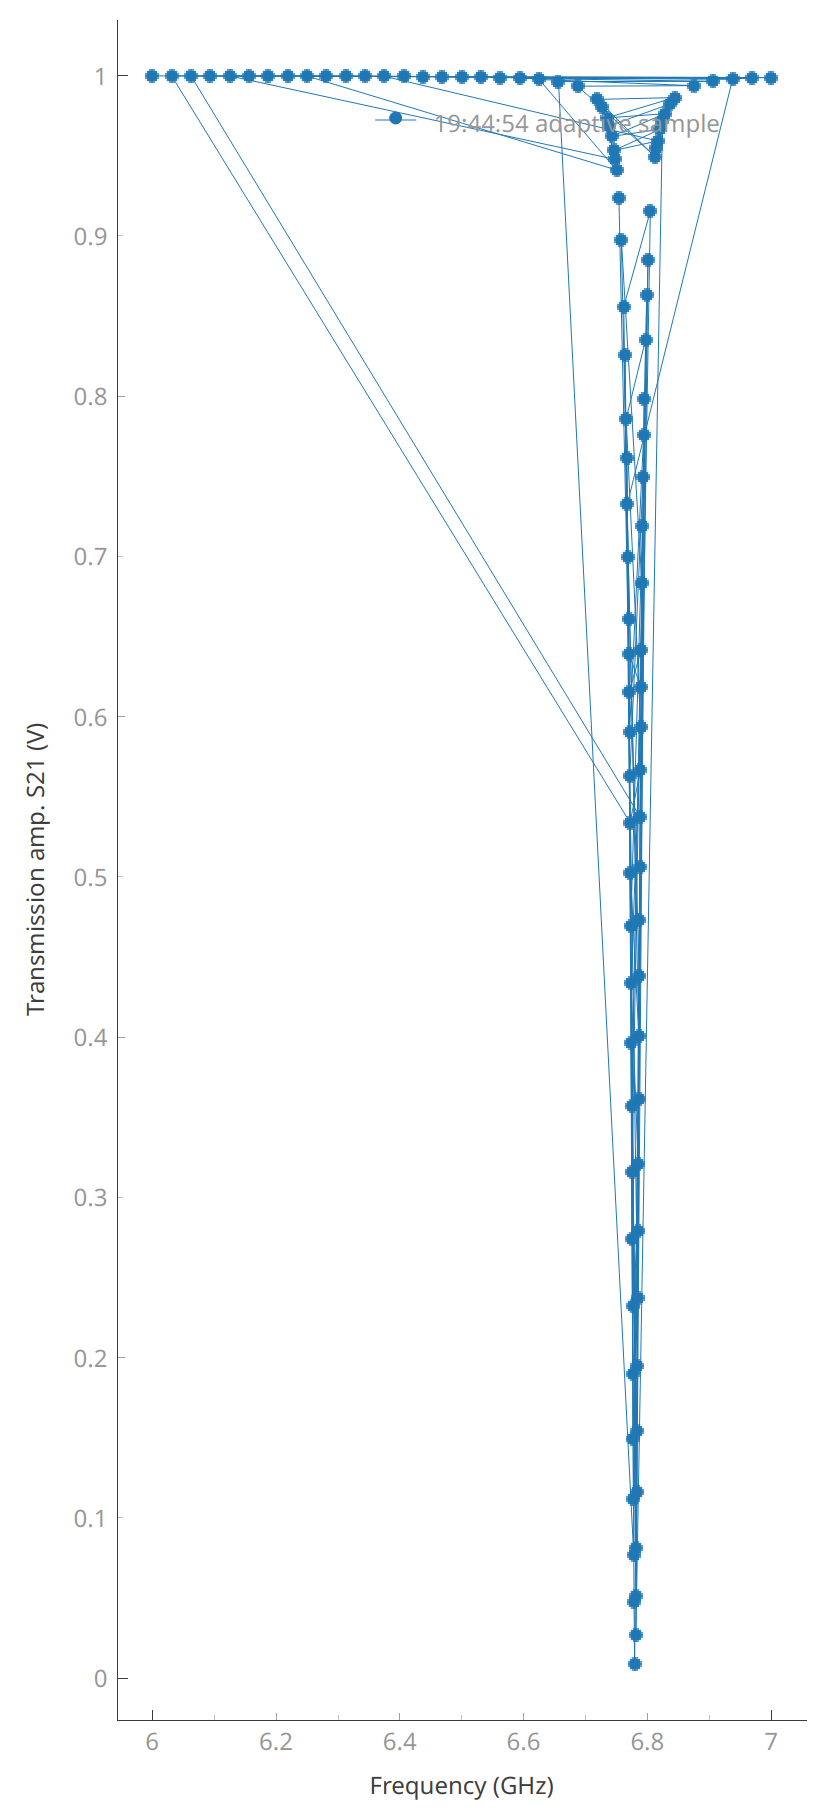

In [15]:
plotmon.main_QtPlot